<a href="https://colab.research.google.com/github/divyabala-ai/telco-customer-churn/blob/main/telco_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn scikit-learn pandas

from google.colab import files

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
uploaded_file = files.upload()

Saving Telco_customer_churn.xlsx to Telco_customer_churn (4).xlsx


In [ ]:
# Loading the file data into a dataframe

file_name = list(uploaded_file.keys())[0]
df = pd.read_excel(file_name)

In [ ]:
# Exploring the data

print(df.head(3))
print(df.info())

   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   

  Paperless Billing    Payment Method  Monthly Charges Total Charges  \
0               Yes      Mailed check            53.85        108.15   
1               Yes  Electronic check            70.70        151.65   
2               Yes  Electronic check            99.65         820.5   

  Churn Label Churn Value Churn Score  CLTV                  Churn Reason  
0         Yes

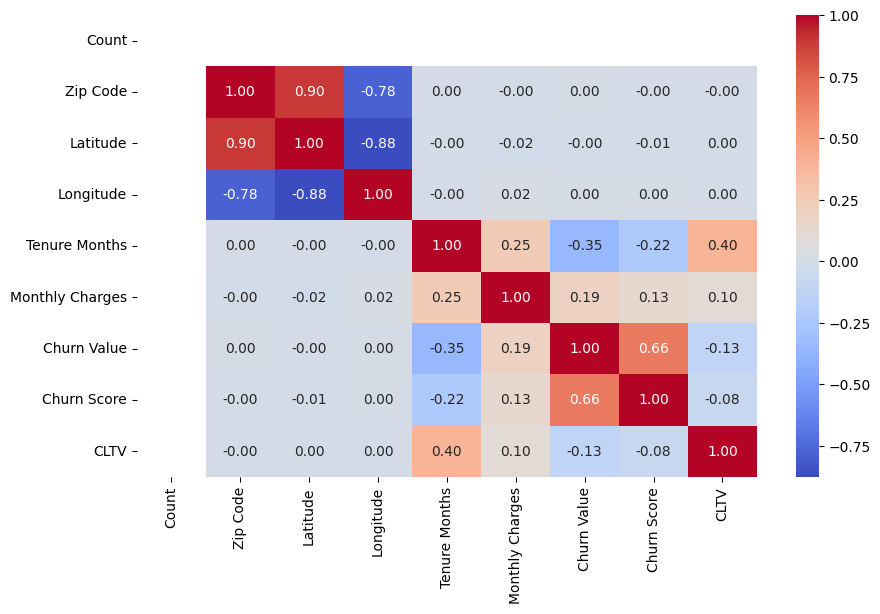

In [ ]:
# Visualize the correlation between numeric fields in the dataset

# Select only numeric columns in the dataset
numeric_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix for numeric columns only
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Churn Value has the most correlation with Churn Score(0.66).


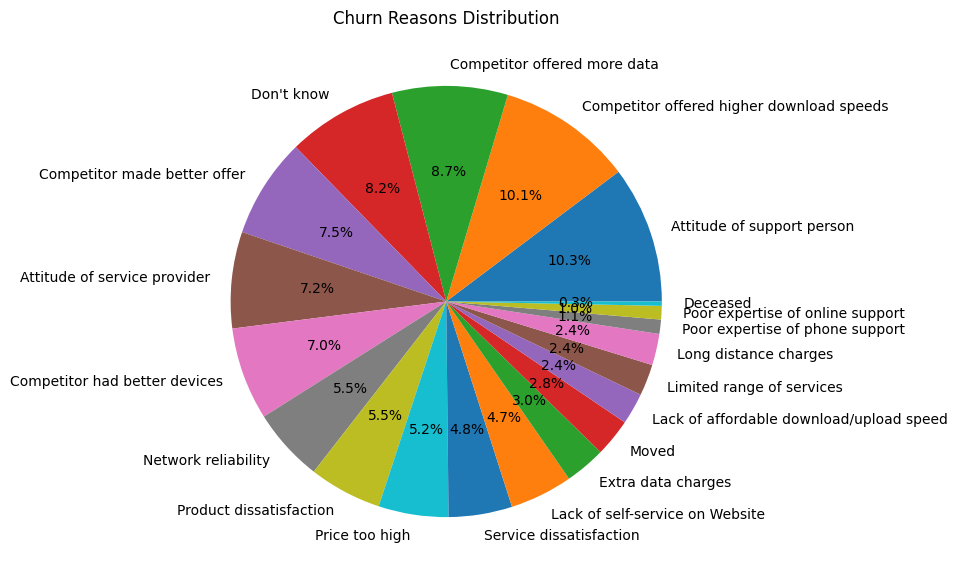

In [ ]:
# Pie chart showing churn reasons

churn_counts = df['Churn Reason'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%')
plt.title("Churn Reasons Distribution")
plt.show()

In [ ]:
# Perform class balancing using SMOTE

X = df.drop('Churn Value', axis=1)
y = df['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train[numerical_columns], y_train)

print("Before balancing:")
print("Churn:", y_train.value_counts()[1])
print("No Churn:", y_train.value_counts()[0])

print("\nAfter balancing:")
print("Churn:", y_train_balanced.value_counts()[1])
print("No Churn:", y_train_balanced.value_counts()[0])

Before balancing:
Churn: 1469
No Churn: 4165

After balancing:
Churn: 4165
No Churn: 4165


In [ ]:
# Feature selection using SelectKBest

k = 5  # number of features to select
selector = SelectKBest(mutual_info_classif, k=k)

X_train_balanced_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test[numerical_columns])

# Print the selected features and the mutual information scores
selected_features = selector.get_feature_names_out()
selected_scores = selector.scores_[selector.get_support()]
print("Selected features and mutual information scores:")
for feature, score in zip(selected_features, selected_scores):
    print(f"{feature}: {score}")

Selected features and mutual information scores:
Zip Code: 0.07581507950639699
Longitude: 0.08317864372694705
Tenure Months: 0.10217252389681497
Monthly Charges: 0.10903151077754214
Churn Score: 0.46104637176085794


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'n_neighbors': 3}
Best Accuracy: 0.8984393757503002
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1009
           1       0.71      0.84      0.77       400

    accuracy                           0.86      1409
   macro avg       0.82      0.85      0.83      1409
weighted avg       0.87      0.86      0.86      1409



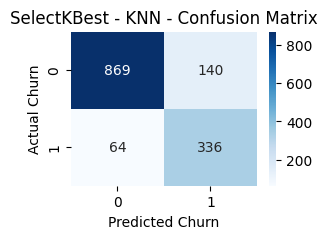

Accuracy scores for each fold:  [0.88955582 0.89855942 0.87815126 0.88895558 0.8997599 ]
Precision scores for each fold:  [0.85157096 0.86244541 0.8469163  0.85140998 0.86754967]
Recall scores for each fold:  [0.94357743 0.94837935 0.92316927 0.94237695 0.94357743]


In [ ]:
# SelectKBest - GridSearchCV using KNN model to predict customer churn

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Perform GridSearchCV on the KNN classifier
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11]}
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=None, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train_balanced_selected, y_train_balanced)

print("Best Hyperparameters:", grid_search_knn.best_params_)
print("Best Accuracy:", grid_search_knn.best_score_)

# Use the best KNN model to predict customer churn
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_selected)

# Print the classification report
print(classification_report(y_test, y_pred_knn))

# Print the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(3,2))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('SelectKBest - KNN - Confusion Matrix')
plt.show()

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall']
cv_results_knn = cross_validate(knn, X_train_balanced_selected, y_train_balanced, cv=cv, scoring=scoring_metrics)

print("Accuracy scores for each fold: ", cv_results_knn['test_accuracy'])
print("Precision scores for each fold: ", cv_results_knn['test_precision'])
print("Recall scores for each fold: ", cv_results_knn['test_recall'])

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Accuracy: 0.9258103241296519
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1009
           1       0.76      0.91      0.83       400

    accuracy                           0.89      1409
   macro avg       0.86      0.90      0.88      1409
weighted avg       0.91      0.89      0.90      1409



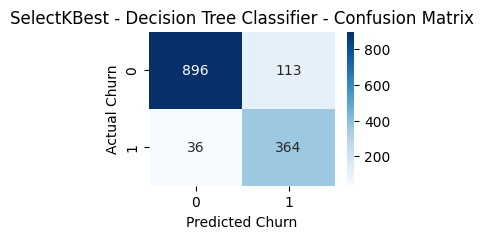

Accuracy scores for each fold:  [0.91836735 0.91476591 0.90456182 0.91776711 0.90816327]
Precision scores for each fold:  [0.91048292 0.90504103 0.90898058 0.9223301  0.90380048]
Recall scores for each fold:  [0.92797119 0.92677071 0.89915966 0.91236495 0.91356543]


In [ ]:
# SelectKBest -  GridSearchCV using Decision Tree model to predict customer churn

# Initialize the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV on the Decision Tree classifier
param_grid_dt = {
    'max_depth': [3, 5, 10, None],  # Try different depths of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required in a leaf node
    'criterion': ['gini', 'entropy'],  # Try both Gini and Entropy for split criterion
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider for the best split
}
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=None, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_dt.fit(X_train_balanced_selected, y_train_balanced)

print("Best Hyperparameters:", grid_search_dt.best_params_)
print("Best Accuracy:", grid_search_dt.best_score_)

# Use the best Decision Tree Classifier model to predict customer churn
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_selected)

# Print the classification report
print(classification_report(y_test, y_pred_dt))

# Print the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(3,2))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('SelectKBest - Decision Tree Classifier - Confusion Matrix')
plt.show()

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall']
cv_results_dt = cross_validate(dt, X_train_balanced_selected, y_train_balanced, cv=cv, scoring=scoring_metrics)

print("Accuracy scores for each fold: ", cv_results_dt['test_accuracy'])
print("Precision scores for each fold: ", cv_results_dt['test_precision'])
print("Recall scores for each fold: ", cv_results_dt['test_recall'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Best Accuracy: 0.9382953181272509
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1009
           1       0.78      0.91      0.84       400

    accuracy                           0.90      1409
   macro avg       0.87      0.90      0.88      1409
weighted avg       0.91      0.90      0.90      1409



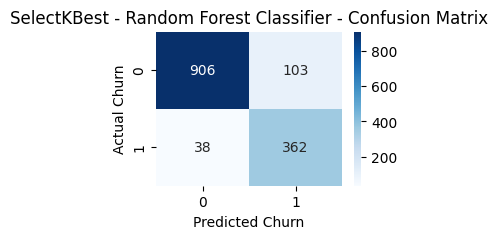

Accuracy scores for each fold:  [0.93337335 0.92797119 0.93277311 0.94537815 0.93517407]
Precision scores for each fold:  [0.91022727 0.90836197 0.91294387 0.93341121 0.91907514]
Recall scores for each fold:  [0.96158463 0.95198079 0.95678271 0.95918367 0.95438175]


In [ ]:
# SelectKBest -  GridSearchCV using Random Forest Classifier model to predict customer churn

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV on the Random Forest classifier
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=None, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_balanced_selected, y_train_balanced)

print("Best Hyperparameters:", grid_search_rf.best_params_)
print("Best Accuracy:", grid_search_rf.best_score_)

# Use the best Random Forest Classifier model to predict customer churn
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_selected)

# Print the classification report
print(classification_report(y_test, y_pred_rf))

# Print the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(3,2))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('SelectKBest - Random Forest Classifier - Confusion Matrix')
plt.show()

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall']
cv_results_rf = cross_validate(rf, X_train_balanced_selected, y_train_balanced, cv=cv, scoring=scoring_metrics)

print("Accuracy scores for each fold: ", cv_results_rf['test_accuracy'])
print("Precision scores for each fold: ", cv_results_rf['test_precision'])
print("Recall scores for each fold: ", cv_results_rf['test_recall'])

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 1.0}
Best Accuracy: 0.9351740696278512
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1009
           1       0.78      0.91      0.84       400

    accuracy                           0.90      1409
   macro avg       0.87      0.90      0.88      1409
weighted avg       0.91      0.90      0.90      1409



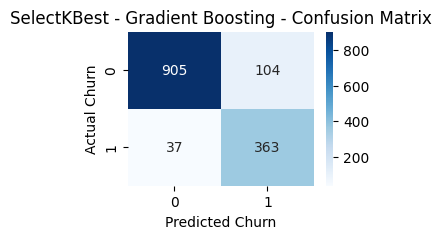

Accuracy scores for each fold:  [0.93157263 0.92677071 0.92256903 0.94417767 0.93757503]
Precision scores for each fold:  [0.90805902 0.90078918 0.90552995 0.93529412 0.92631579]
Recall scores for each fold:  [0.96038415 0.95918367 0.94357743 0.95438175 0.95078031]


In [ ]:
# SelectKBest -  GridSearchCV using Gradient Boosting to predict customer churn

# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV on the Gradient Boosting model
param_grid_gb = {
    'n_estimators': [100, 150],  # Number of trees in the forest
    'learning_rate': [0.05, 0.1],  # Step size
    'max_depth': [3, 5],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum samples required to be at a leaf node
    'subsample': [0.8, 1.0],  # Fraction of samples used for fitting each base learner
    'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=None, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train_balanced_selected, y_train_balanced)

print("Best Hyperparameters:", grid_search_gb.best_params_)
print("Best Accuracy:", grid_search_gb.best_score_)

# Use the best Gradient Boosting model to predict customer churn
best_gb = grid_search_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test_selected)

# Print the classification report
print(classification_report(y_test, y_pred_gb))

# Print the confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(3,2))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('SelectKBest - Gradient Boosting - Confusion Matrix')
plt.show()

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall']
cv_results_gb = cross_validate(gb, X_train_balanced_selected, y_train_balanced, cv=cv, scoring=scoring_metrics)

print("Accuracy scores for each fold: ", cv_results_gb['test_accuracy'])
print("Precision scores for each fold: ", cv_results_gb['test_precision'])
print("Recall scores for each fold: ", cv_results_gb['test_recall'])

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy: 0.9355342136854741
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1009
           1       0.76      0.90      0.83       400

    accuracy                           0.89      1409
   macro avg       0.86      0.89      0.87      1409
weighted avg       0.90      0.89      0.90      1409



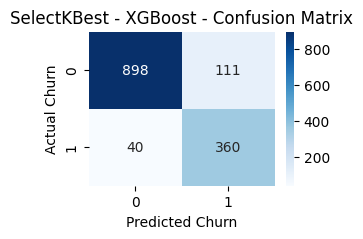

Accuracy scores for each fold:  [0.93637455 0.92316927 0.92917167 0.94717887 0.94057623]
Precision scores for each fold:  [0.9163803  0.90193843 0.91234141 0.93263647 0.92773893]
Recall scores for each fold:  [0.96038415 0.94957983 0.94957983 0.96398559 0.95558223]


In [ ]:
# SelectKBest -  GridSearchCV using XGBoost to predict customer churn

# Initialize the XGBoost model
xgb = XGBClassifier(random_state=42)

# # Perform GridSearchCV on the XGBoost model
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=None, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train_balanced_selected, y_train_balanced)

print("Best Hyperparameters:", grid_search_xgb.best_params_)
print("Best Accuracy:", grid_search_xgb.best_score_)

# Use the best XGBoost model to predict customer churn
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_selected)

# Print the classification report
print(classification_report(y_test, y_pred_xgb))

# Print the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(3,2))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('SelectKBest - XGBoost - Confusion Matrix')
plt.show()

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall']
cv_results_xgb = cross_validate(xgb, X_train_balanced_selected, y_train_balanced, cv=cv, scoring=scoring_metrics)

print("Accuracy scores for each fold: ", cv_results_xgb['test_accuracy'])
print("Precision scores for each fold: ", cv_results_xgb['test_precision'])
print("Recall scores for each fold: ", cv_results_xgb['test_recall'])

In [ ]:
# Dimensionality reduction using PCA

# Scale the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)

# Scale the test data
# Select only numerical columns from X_test to match X_train_balanced
X_test_selected_for_scaling = X_test[X_train_balanced.columns]  # Selecting the same columns used for training
X_test_scaled = scaler.transform(X_test_selected_for_scaling) # Transforming the selected columns

# Perform PCA on the scaled training data, selecting the top 5 components
pca = PCA(n_components=5)
X_train_balanced_pca = pca.fit_transform(X_train_scaled)

# Apply the same PCA transformation to the scaled test data
X_test_pca = pca.transform(X_test_scaled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'n_neighbors': 9}
Best Accuracy: 0.9175270108043219
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1009
           1       0.71      0.90      0.79       400

    accuracy                           0.86      1409
   macro avg       0.83      0.87      0.84      1409
weighted avg       0.88      0.86      0.87      1409



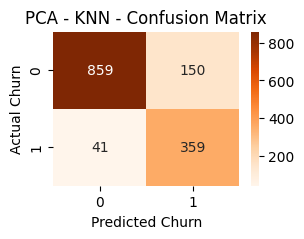

Accuracy scores for each fold:  [0.91536615 0.90156062 0.90216086 0.92136855 0.91956783]
Precision scores for each fold:  [0.88444444 0.87208009 0.87057522 0.89795918 0.89761092]
Recall scores for each fold:  [0.95558223 0.94117647 0.94477791 0.95078031 0.94717887]


In [ ]:
# PCA - GridSearchCV using KNN model to predict customer churn

# Initialize the KNN classifier
knn_pca = KNeighborsClassifier()

# Perform GridSearchCV on the KNN classifier
param_grid_knn_pca = {'n_neighbors': [3, 5, 7, 9, 11]}
grid_search_knn_pca = GridSearchCV(estimator=knn_pca, param_grid=param_grid_knn_pca, cv=None, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_knn_pca.fit(X_train_balanced_pca, y_train_balanced)

print("Best Hyperparameters:", grid_search_knn_pca.best_params_)
print("Best Accuracy:", grid_search_knn_pca.best_score_)

# Use the best KNN model to predict customer churn
best_knn_pca = grid_search_knn_pca.best_estimator_
y_pred_knn_pca = best_knn_pca.predict(X_test_pca)

# Print the classification report
print(classification_report(y_test, y_pred_knn_pca))

# Print the confusion matrix
cm_knn_pca = confusion_matrix(y_test, y_pred_knn_pca)

plt.figure(figsize=(3,2))
sns.heatmap(cm_knn_pca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('PCA - KNN - Confusion Matrix')
plt.show()

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall']
cv_results_knn_pca = cross_validate(knn_pca, X_train_balanced_pca, y_train_balanced, cv=cv, scoring=scoring_metrics)

print("Accuracy scores for each fold: ", cv_results_knn_pca['test_accuracy'])
print("Precision scores for each fold: ", cv_results_knn_pca['test_precision'])
print("Recall scores for each fold: ", cv_results_knn_pca['test_recall'])

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.9094837935174069
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1009
           1       0.72      0.85      0.78       400

    accuracy                           0.87      1409
   macro avg       0.83      0.86      0.84      1409
weighted avg       0.88      0.87      0.87      1409



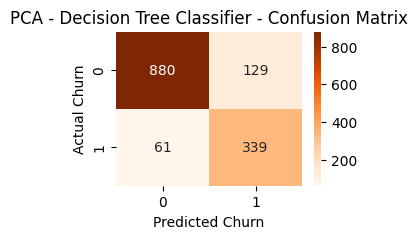

Accuracy scores for each fold:  [0.89855942 0.88715486 0.88535414 0.89495798 0.89795918]
Precision scores for each fold:  [0.88967136 0.87197232 0.88123515 0.90318627 0.89891697]
Recall scores for each fold:  [0.90996399 0.90756303 0.8907563  0.8847539  0.8967587 ]


In [ ]:
# PCA - GridSearchCV using Decision Tree model to predict customer churn

# Initialize the DecisionTreeClassifier
dt_pca = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV on the Decision Tree classifier
param_grid_dt_pca = {
    'max_depth': [3, 5, 10, None],  # Try different depths of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required in a leaf node
    'criterion': ['gini', 'entropy'],  # Try both Gini and Entropy for split criterion
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider for the best split
}
grid_search_dt_pca = GridSearchCV(estimator=dt_pca, param_grid=param_grid_dt_pca, cv=None, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_dt_pca.fit(X_train_balanced_pca, y_train_balanced)

print(f"Best Parameters: {grid_search_dt_pca.best_params_}")
print("Best Accuracy:", grid_search_dt_pca.best_score_)

# Use the best Decision Tree Classifier model to predict customer churn
best_dt_pca = grid_search_dt_pca.best_estimator_
y_pred_dt_pca = best_dt_pca.predict(X_test_pca)

# Print the classification report
print(classification_report(y_test, y_pred_dt_pca))

# Print the confusion matrix
cm_dt_pca = confusion_matrix(y_test, y_pred_dt_pca)

plt.figure(figsize=(3,2))
sns.heatmap(cm_dt_pca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('PCA - Decision Tree Classifier - Confusion Matrix')
plt.show()

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall']
cv_results_dt_pca = cross_validate(dt_pca, X_train_balanced_pca, y_train_balanced, cv=cv, scoring=scoring_metrics)

print("Accuracy scores for each fold: ", cv_results_dt_pca['test_accuracy'])
print("Precision scores for each fold: ", cv_results_dt_pca['test_precision'])
print("Recall scores for each fold: ", cv_results_dt_pca['test_recall'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best Accuracy: 0.9331332533013205
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1009
           1       0.76      0.89      0.82       400

    accuracy                           0.89      1409
   macro avg       0.85      0.89      0.87      1409
weighted avg       0.90      0.89      0.89      1409



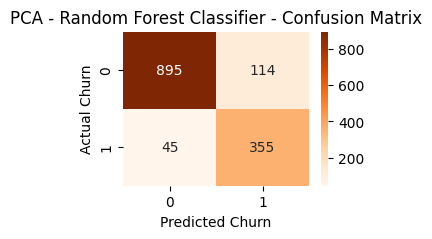

Accuracy scores for each fold:  [0.92977191 0.91956783 0.92256903 0.94177671 0.94297719]
Precision scores for each fold:  [0.90681818 0.89761092 0.90366972 0.93294118 0.93411765]
Recall scores for each fold:  [0.95798319 0.94717887 0.94597839 0.95198079 0.95318127]


In [ ]:
# PCA -  GridSearchCV using Random Forest Classifier model to predict customer churn

# Initialize the Random Forest Classifier
rf_pca = RandomForestClassifier(random_state=42)

# Perform GridSearchCV on the Random Forest classifier
param_grid_rf_pca = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
grid_search_rf_pca = GridSearchCV(estimator=rf_pca, param_grid=param_grid_rf_pca, cv=None, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf_pca.fit(X_train_balanced_pca, y_train_balanced)

print("Best Hyperparameters:", grid_search_rf_pca.best_params_)
print("Best Accuracy:", grid_search_rf_pca.best_score_)

# Use the best Random Forest Classifier model to predict customer churn
best_rf_pca = grid_search_rf_pca.best_estimator_
y_pred_rf_pca = best_rf_pca.predict(X_test_pca)

# Print the classification report
print(classification_report(y_test, y_pred_rf_pca))

# Print the confusion matrix
cm_rf_pca = confusion_matrix(y_test, y_pred_rf_pca)

plt.figure(figsize=(3,2))
sns.heatmap(cm_rf_pca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('PCA - Random Forest Classifier - Confusion Matrix')
plt.show()

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall']
cv_results_rf_pca = cross_validate(rf_pca, X_train_balanced_pca, y_train_balanced, cv=cv, scoring=scoring_metrics)

print("Accuracy scores for each fold: ", cv_results_rf_pca['test_accuracy'])
print("Precision scores for each fold: ", cv_results_rf_pca['test_precision'])
print("Recall scores for each fold: ", cv_results_rf_pca['test_recall'])

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}
Best Accuracy: 0.9279711884753901
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1009
           1       0.76      0.87      0.81       400

    accuracy                           0.88      1409
   macro avg       0.85      0.88      0.86      1409
weighted avg       0.89      0.88      0.89      1409



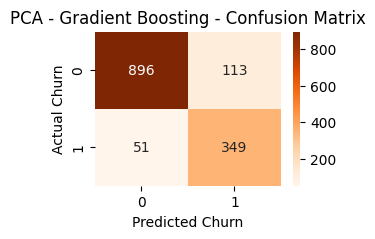

Accuracy scores for each fold:  [0.91896759 0.90816327 0.90876351 0.93277311 0.92677071]
Precision scores for each fold:  [0.89213483 0.88636364 0.89182969 0.92163743 0.91872792]
Recall scores for each fold:  [0.95318127 0.93637455 0.93037215 0.94597839 0.93637455]


In [ ]:
# PCA -  GridSearchCV using Gradient Boosting to predict customer churn

# Initialize the Gradient Boosting model
gb_pca = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV on the Gradient Boosting model
param_grid_gb_pca = {
    'n_estimators': [100, 150],  # Number of trees in the forest
    'learning_rate': [0.05, 0.1],  # Step size
    'max_depth': [3, 5],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum samples required to be at a leaf node
    'subsample': [0.8, 1.0],  # Fraction of samples used for fitting each base learner
    'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}
grid_search_gb_pca = GridSearchCV(estimator=gb_pca, param_grid=param_grid_gb_pca, cv=None, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_gb_pca.fit(X_train_balanced_pca, y_train_balanced)

print("Best Hyperparameters:", grid_search_gb_pca.best_params_)
print("Best Accuracy:", grid_search_gb_pca.best_score_)

# Use the best Gradient Boosting model to predict customer churn
best_gb_pca = grid_search_gb_pca.best_estimator_
y_pred_gb_pca = best_gb_pca.predict(X_test_pca)

# Print the classification report
print(classification_report(y_test, y_pred_gb_pca))

# Print the confusion matrix
cm_gb_pca = confusion_matrix(y_test, y_pred_gb_pca)

plt.figure(figsize=(3,2))
sns.heatmap(cm_gb_pca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('PCA - Gradient Boosting - Confusion Matrix')
plt.show()

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall']
cv_results_gb_pca = cross_validate(gb_pca, X_train_balanced_pca, y_train_balanced, cv=cv, scoring=scoring_metrics)

print("Accuracy scores for each fold: ", cv_results_gb_pca['test_accuracy'])
print("Precision scores for each fold: ", cv_results_gb_pca['test_precision'])
print("Recall scores for each fold: ", cv_results_gb_pca['test_recall'])

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy: 0.9278511404561826
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1009
           1       0.75      0.89      0.81       400

    accuracy                           0.89      1409
   macro avg       0.85      0.89      0.87      1409
weighted avg       0.89      0.89      0.89      1409



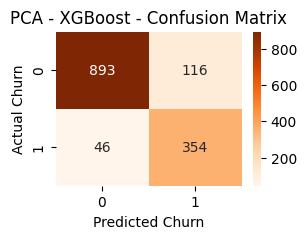

Accuracy scores for each fold:  [0.92797119 0.90996399 0.92016807 0.93577431 0.93577431]
Precision scores for each fold:  [0.90649943 0.89388697 0.90322581 0.92505855 0.92907801]
Recall scores for each fold:  [0.95438175 0.93037215 0.94117647 0.94837935 0.94357743]


In [ ]:
# PCA -  GridSearchCV using XGBoost to predict customer churn

# Initialize the XGBoost model
xgb_pca = XGBClassifier(random_state=42)

# # Perform GridSearchCV on the XGBoost model
param_grid_xgb_pca = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid_search_xgb_pca = GridSearchCV(estimator=xgb_pca, param_grid=param_grid_xgb_pca, cv=None, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_xgb_pca.fit(X_train_balanced_pca, y_train_balanced)

print("Best Hyperparameters:", grid_search_xgb_pca.best_params_)
print("Best Accuracy:", grid_search_xgb_pca.best_score_)

# Use the best XGBoost model to predict customer churn
best_xgb_pca = grid_search_xgb_pca.best_estimator_
y_pred_xgb_pca = best_xgb_pca.predict(X_test_pca)

# Print the classification report
print(classification_report(y_test, y_pred_xgb_pca))

# Print the confusion matrix
cm_xgb_pca = confusion_matrix(y_test, y_pred_xgb_pca)

plt.figure(figsize=(3,2))
sns.heatmap(cm_xgb_pca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('PCA - XGBoost - Confusion Matrix')
plt.show()

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall']
cv_results_xgb_pca = cross_validate(xgb_pca, X_train_balanced_pca, y_train_balanced, cv=cv, scoring=scoring_metrics)

print("Accuracy scores for each fold: ", cv_results_xgb_pca['test_accuracy'])
print("Precision scores for each fold: ", cv_results_xgb_pca['test_precision'])
print("Recall scores for each fold: ", cv_results_xgb_pca['test_recall'])

Some observations:


1. The accuracy values are similar between the various models using both SelectKBest and PCA.
2. Random Forest Classifier model had the highest accuracy using both SelectKBest and PCA.
3. KNN and Decision Tree models had the lowest 2 accuracy values using both SelectKBest and PCA.
4. Generally, the precision values for 'no churn'(churn value = 0) is in the 0.90s but the precision values for 'churn'(churn value = 1) is in the 0.70s





